In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torch.linalg import vector_norm as vnorm
from torch.linalg import solve as solve_matrix_system

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

from telegramBot import Terminator

num_cores = 8
torch.set_num_interop_threads(num_cores) # Inter-op parallelism
torch.set_num_threads(num_cores) # Intra-op parallelism

In [2]:
torch.autograd.set_detect_anomaly(False);
torch.autograd.profiler.emit_nvtx(False);
torch.autograd.profiler.profile(False);
#torch.autograd.gradcheck(False)
#torch.autograd.gradgradcheck(False)

In [3]:
def c3_to_c1(y):
    if y < 2 or y > 7:
        return 0
    return 1

def c3_to_c2(y):
    match y:
        case 0:
            return 0
        case 1:
            return 2
        case 2:
            return 3
        case 3:
            return 5
        case 4:
            return 6
        case 5:
            return 5
        case 6:
            return 4
        case 7:
            return 6
        case 8:
            return 1
        case _:
            return 2

def c2_to_c1(y):
    if y < 3:
        return 0
    return 1

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

coarser = Lambda(lambda y: torch.tensor([c3_to_c1(y), c3_to_c2(y), int(y)]))

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform, target_transform = coarser)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_cores)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform, target_transform = coarser)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_cores)

In [5]:
class HCNN3_oca(nn.Module):
    def __init__(self, learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, 
                 every_print = 512, training_size = 50000):
        
        super().__init__()
        self.trainloader = trainloader
        self.testloader = testloader
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.nesterov = nesterov
        self.activation = F.relu
        self.class_levels = 3
        self.num_c_1 = num_class_c1
        self.num_c_2 = num_class_c2
        self.num_c_3 = num_class_c3
        self.epochs = epochs
        self.labels_c_1 = labels_c_1
        self.labels_c_2 = labels_c_2
        self.labels_c_3 = labels_c_3
        self.every_print = every_print - 1 # assumed power of 2, -1 to make the mask
        self.track_size = int( training_size / batch_size / every_print ) 

        self.layer1  = nn.Conv2d(3, 64, (3,3), padding = 'same', bias = False)
        self.layer2  = nn.BatchNorm2d(64)
        self.layer3  = nn.Conv2d(64, 64, (3,3), padding = 'same', bias = False)
        self.layer4  = nn.BatchNorm2d(64)
        self.layer5  = nn.MaxPool2d((2,2), stride = (2,2))

        self.layer6  = nn.Conv2d(64, 128, (3,3), padding = 'same', bias = False)
        self.layer7  = nn.BatchNorm2d(128)
        self.layer8  = nn.Conv2d(128, 128, (3,3), padding = 'same', bias = False)
        self.layer9  = nn.BatchNorm2d(128)
        self.layer10 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layer10_1  = nn.Conv2d(128, 256, (3,3), padding = 'same', bias = False)
        self.layer10_2  = nn.BatchNorm2d(256)
        #self.layer8  = nn.Conv2d(128, 128, (3,3), padding = 'same', bias = False)
        #self.layer9  = nn.BatchNorm2d(128)
        self.layer10_3 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layerb11 = nn.Linear(4*4*256, 256, bias = False)
        self.layerb12 = nn.BatchNorm1d(256)
        self.layerb13 = nn.Dropout(0.5)
        self.layerb14 = nn.Linear(256, 256, bias = False)
        self.layerb15 = nn.BatchNorm1d(256)
        self.layerb16 = nn.Dropout(0.5)
        self.layerb_mid = nn.Linear(256, 256)
        self.layerb17 = nn.Linear(256, self.num_c_1)
        
        self.layerb27 = nn.Linear(256, self.num_c_2)
        self.layerb27_ = nn.Linear(self.num_c_1, self.num_c_2)
        
        self.layerb37 = nn.Linear(256, self.num_c_3)
        self.layerb37_ = nn.Linear(self.num_c_2, self.num_c_3)


        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[0], 
                                   momentum = self.momentum, nesterov = self.nesterov)
        self.criterion = nn.CrossEntropyLoss()

    
    def forward(self, x):

        # block 1
        z = self.layer1(x)
        z = self.activation(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.activation(z)
        z = self.layer4(z)
        z = self.layer5(z)

        # block 2
        z = self.layer6(z)
        z = self.activation(z)
        z = self.layer7(z)
        z = self.layer8(z)
        z = self.activation(z)
        z = self.layer9(z)
        z = self.layer10(z)

        # block 3
        z = self.layer10_1(z)
        z = self.activation(z)
        z = self.layer10_2(z)
        z = self.layer10_3(z)
        
        z = torch.flatten(z, start_dim = 1)

        # branch 1
        z = self.layerb11(z)
        z = self.activation(z)
        z = self.layerb12(z)
        z = self.layerb13(z)
        z = self.layerb14(z)
        z = self.activation(z)
        z = self.layerb15(z)
        z = self.layerb16(z)
        z = self.layerb_mid(z)
        z = self.activation(z)

        # projections
        ort2, ort3 = self.project(z)

        # branch 1
        b1 = self.layerb17(z)
        
        # branch 2
        b2 = self.layerb27(ort2) + self.layerb27_(b1.clone().detach())

        # branch 3
        b3 = self.layerb37(ort3) + self.layerb37_(b2.clone().detach())

        return b1, b2, b3

    
    # Assumption: W is column full rank. 
    def project(self, z): # https://math.stackexchange.com/questions/4021915/projection-orthogonal-to-two-vectors

        W1 = self.layerb17.weight.clone().detach()
        W2 = self.layerb27.weight.clone().detach()
        ort2 = torch.empty_like(z)
        ort3 = torch.empty_like(z)

        for i, zi in enumerate(z):
            Rk = torch.diag(torch.where(zi.clone().detach() != 0, 1.0, 0.0))
            W1k = W1.mm(Rk)
            W2k_ = W2.mm(Rk)
            W2k = torch.vstack((W1k, W2k_))
            ort2[i,:] = self.compute_othogonal(zi, W1k)
            ort3[i,:] = self.compute_othogonal(zi, W2k)
            
        #prj2 = z.clone().detach() - ort2.clone().detach()
        #prj3 = z.clone().detach() - ort3.clone().detach()
        
        return ort2, ort3, #prj2, ort2, prj3, ort3

    def compute_othogonal(self, z, W, eps = 1e-8):
        WWT = torch.matmul(W, W.T)
        P = solve_matrix_system(WWT + torch.randn_like(WWT) * eps, torch.eye(W.size(0)))
        P = torch.matmul(P, W)
        P = torch.eye(W.size(1)) - torch.matmul(W.T, P)
        
        return torch.matmul(z, P)

    
    def update_training_params(self, epoch):
        if epoch == 41:
            self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[1], 
                               momentum = self.momentum, nesterov = self.nesterov)
        elif epoch == 51:
            self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[2], 
                               momentum = self.momentum, nesterov = self.nesterov)


    def predict_and_learn(self, batch, labels):
        self.optimizer.zero_grad()
        predict = self(batch)
        loss_f = self.criterion(predict[0], labels[:,0])
        loss_i1 = self.criterion(predict[1], labels[:,1])
        loss_i2 = self.criterion(predict[2], labels[:,2])
        
        loss_f.backward(retain_graph=True)
        loss_i1.backward(retain_graph=True)
        loss_i2.backward()

        self.optimizer.step()

        return torch.tensor([loss_f, loss_i1, loss_i2])

    
    def train_model(self, verbose = False):
        self.train()
        
        for epoch in tqdm(np.arange(self.epochs), desc="Training: "):
            #self.update_training_params(epoch)

            if verbose:
                running_loss = torch.zeros(self.class_levels)
            
            for iter, (batch, labels) in enumerate(self.trainloader):
                loss = self.predict_and_learn(batch, labels)

                if verbose:
                    running_loss += (loss - running_loss) / (iter+1)
                    if (iter + 1) & self.every_print == 0:
                        print(f'[{epoch + 1}] loss_f : {running_loss[0] :.3f}')
                        print(f'[{epoch + 1}] loss_i1: {running_loss_[1] :.3f}')
                        print(f'[{epoch + 1}] loss_i2: {running_loss_[2] :.3f}')
                        for i in np.arange(self.class_levels):
                            running_loss[i] = 0.0

    
    def train_track(self, filename = ""):
        self.train()
        
        self.loss_track = torch.zeros(self.epochs * self.track_size, self.class_levels)
        self.accuracy_track = torch.zeros(self.epochs * self.track_size, self.class_levels)
        num_push = 0
        
        for epoch in tqdm(np.arange(self.epochs), desc="Training: "):
            #self.update_training_params(epoch)

            running_loss = torch.zeros(self.class_levels)
            
            for iter, (batch, labels) in enumerate(self.trainloader):
                loss = self.predict_and_learn(batch, labels)

                running_loss += (loss - running_loss) / (iter+1)
                if (iter + 1) & self.every_print == 0:
                    self.loss_track[num_push, :] = running_loss
                    self.accuracy_track[num_push, :] = self.test(mode = "train")
                    num_push += 1
                    for i in np.arange(self.class_levels):
                            running_loss[i] = 0.0

        self.plot_training_loss(filename+"_train_loss.pdf")
        self.plot_test_accuracy(filename+"_test_accuracy_.pdf")

    
    def initialize_memory(self):
        self.correct_c1_pred = torch.zeros(self.num_c_1)
        self.total_c1_pred = torch.zeros_like(self.correct_c1_pred)
        
        self.correct_c2_pred = torch.zeros(self.num_c_2)
        self.total_c2_pred = torch.zeros_like(self.correct_c2_pred)
        
        self.correct_c3_pred = torch.zeros(self.num_c_3)
        self.total_c3_pred = torch.zeros_like(self.correct_c3_pred)

        self.correct_c1_vs_c2_pred = torch.zeros(self.num_c_1)
        self.total_c1_vs_c2_pred = torch.zeros_like(self.correct_c1_vs_c2_pred)

        self.correct_c2_vs_c3_pred = torch.zeros(self.num_c_2)
        self.total_c2_vs_c3_pred = torch.zeros_like(self.correct_c2_vs_c3_pred)

        self.correct_c1_vs_c3_pred = torch.zeros(self.num_c_1)
        self.total_c1_vs_c3_pred = torch.zeros_like(self.correct_c1_vs_c3_pred)

    
    def collect_test_performance(self):
        with torch.no_grad():
            for images, labels in self.testloader:
                predictions = self(images)
                predicted = torch.zeros(predictions[0].size(0), self.class_levels, dtype=torch.long)
                _, predicted[:,0] = torch.max(predictions[0], 1)
                _, predicted[:,1] = torch.max(predictions[1], 1)
                _, predicted[:,2] = torch.max(predictions[2], 1)

                for i in np.arange(predictions[0].size(0)):
                    if labels[i,0] == predicted[i,0]:
                        self.correct_c1_pred[labels[i,0]] += 1
                        
                    if labels[i,1] == predicted[i,1]:
                        self.correct_c2_pred[labels[i,1]] += 1

                    if labels[i,2] == predicted[i,2]:
                        self.correct_c3_pred[labels[i,2]] += 1

                    if predicted[i,1] == c3_to_c2(predicted[i,2]):
                        self.correct_c2_vs_c3_pred[predicted[i,1]] += 1

                    if predicted[i,0] == c3_to_c1(predicted[i,2]):
                        self.correct_c1_vs_c3_pred[predicted[i,0]] += 1

                    if predicted[i,0] == c2_to_c1(predicted[i,1]):
                        self.correct_c1_vs_c2_pred[predicted[i,0]] += 1
                        
                    self.total_c1_pred[labels[i,0]] += 1
                    self.total_c2_pred[labels[i,1]] += 1
                    self.total_c3_pred[labels[i,2]] += 1
                    self.total_c1_vs_c3_pred[predicted[i,0]] += 1
                    self.total_c1_vs_c2_pred[predicted[i,0]] += 1
                    self.total_c2_vs_c3_pred[predicted[i,1]] += 1
                    

    def print_test_results(self):
        # print accuracy for each class
        for i in np.arange(self.num_c_1):
            accuracy_c1 = 100 * float(self.correct_c1_pred[i]) / self.total_c1_pred[i]
            print(f'Accuracy for class {self.labels_c_1[i]:5s}: {accuracy_c1:.2f} %')

        print("")
        for i in np.arange(self.num_c_2):
            accuracy_c2 = 100 * float(self.correct_c2_pred[i]) / self.total_c2_pred[i]
            print(f'Accuracy for class {self.labels_c_2[i]:5s}: {accuracy_c2:.2f} %')

        print("")
        for i in np.arange(self.num_c_3):
            accuracy_c3 = 100 * float(self.correct_c3_pred[i]) / self.total_c3_pred[i]
            print(f'Accuracy for class {self.labels_c_3[i]:5s}: {accuracy_c3:.2f} %')
            
        # print accuracy for the whole dataset
        print("")
        print(f'Accuracy on c1: {(100 * self.correct_c1_pred.sum() / self.total_c1_pred.sum()):.2f} %')
        print(f'Accuracy on c2: {(100 * self.correct_c2_pred.sum() / self.total_c2_pred.sum()):.2f} %')
        print(f'Accuracy on c3: {(100 * self.correct_c3_pred.sum() / self.total_c3_pred.sum()):.2f} %')

        # print cross classes accuracy (tree)
        print("")
        for i in np.arange(self.num_c_1):
            accuracy_c1_c2 = 100 * float(self.correct_c1_vs_c2_pred[i]) / self.total_c1_vs_c2_pred[i]
            print(f'Cross-accuracy {self.labels_c_1[i]:5s} vs c2: {accuracy_c1_c2:.2f} %')
        
        print("")
        for i in np.arange(self.num_c_2):
            accuracy_c2_c3 = 100 * float(self.correct_c2_vs_c3_pred[i]) / self.total_c2_vs_c3_pred[i]
            print(f'Cross-accuracy {self.labels_c_2[i]:5s} vs c3: {accuracy_c2_c3:.2f} %')

        print("")
        for i in np.arange(self.num_c_1):
            accuracy_c1_c3 = 100 * float(self.correct_c1_vs_c3_pred[i]) / self.total_c1_vs_c3_pred[i]
            print(f'Cross-accuracy {self.labels_c_1[i]:5s} vs c3: {accuracy_c1_c3:.2f} %')


    def barplot(self, x, accuracy, labels, title):
        plt.bar(x, accuracy, tick_label = labels)
        plt.xlabel("Classes")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.show();

    
    def plot_test_results(self):
        # accuracy for each class
        accuracy_c1 = torch.empty(self.num_c_1)
        for i in np.arange(self.num_c_1):
            accuracy_c1[i] = float(self.correct_c1_pred[i]) / self.total_c1_pred[i]
        self.barplot(np.arange(self.num_c_1), accuracy_c1, self.labels_c_1, "Accuracy on the first level")

        accuracy_c2 = torch.empty(self.num_c_2 + 1)
        for i in np.arange(self.num_c_2):
            accuracy_c2[i] = float(self.correct_c2_pred[i]) / self.total_c2_pred[i]
        accuracy_c2[self.num_c_2] = self.correct_c2_pred.sum() / self.total_c2_pred.sum()
        self.barplot(np.arange(self.num_c_2 + 1), accuracy_c2, (*self.labels_c_2, 'overall'), "Accuracy on the second level")

        accuracy_c3 = torch.empty(self.num_c_3 + 1)
        for i in np.arange(self.num_c_3):
            accuracy_c3[i] = float(self.correct_c3_pred[i]) / self.total_c3_pred[i]
        accuracy_c3[self.num_c_3] = self.correct_c3_pred.sum() / self.total_c3_pred.sum()
        self.barplot(np.arange(self.num_c_3 + 1), accuracy_c3, (*self.labels_c_3, 'overall'), "Accuracy on the third level")

    
    def test(self, mode = "print"):
        self.initialize_memory()
        self.eval()

        self.collect_test_performance()

        match mode:
            case "plot":
                self.plot_test_results()
            case "print":
                self.print_test_results()
            case "train":
                accuracy_c1 = self.correct_c1_pred.sum() / self.total_c1_pred.sum()
                accuracy_c2 = self.correct_c2_pred.sum() / self.total_c2_pred.sum()
                accuracy_c3 = self.correct_c3_pred.sum() / self.total_c3_pred.sum()

                self.train()

                return torch.tensor([accuracy_c1, accuracy_c2, accuracy_c3])
            case _:
                raise AttributeError("Test mode not available")
        
    
    def plot_training_loss(self, filename = None):
        plt.figure(figsize=(12, 6))
        plt.plot(np.linspace(1, self.epochs, self.loss_track.size(0)), self.loss_track[:, 0].numpy(), label = "First level")
        plt.plot(np.linspace(1, self.epochs, self.loss_track.size(0)), self.loss_track[:, 1].numpy(), label = "Second level")
        plt.plot(np.linspace(1, self.epochs, self.loss_track.size(0)), self.loss_track[:, 2].numpy(), label = "Third level")
        plt.title("Training loss")
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.xticks(np.linspace(1, self.epochs, self.epochs)[0::2])
        plt.legend()
        if filename is not None:
            plt.savefig(filename, bbox_inches='tight')
        plt.show();

    
    def plot_test_accuracy(self, filename = None):
        plt.figure(figsize=(12, 6))
        plt.plot(np.linspace(1, self.epochs, self.accuracy_track.size(0)), self.accuracy_track[:, 0].numpy(), label = "First level")
        plt.plot(np.linspace(1, self.epochs, self.accuracy_track.size(0)), self.accuracy_track[:, 1].numpy(), label = "Second level")
        plt.plot(np.linspace(1, self.epochs, self.accuracy_track.size(0)), self.accuracy_track[:, 2].numpy(), label = "Third level")
        plt.title("Test accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.xticks(np.linspace(1, self.epochs, self.epochs)[0::2])
        plt.legend()
        if filename is not None:
            plt.savefig(filename, bbox_inches='tight')
        plt.show();

    
    def save_model(self, path):
        torch.save(self.state_dict(), path)

    
    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()

In [6]:
learning_rate = [3e-3, 5e-4, 1e-4]
momentum = 0.9
nesterov = True
epochs = 60
num_class_c1 = 2
num_class_c2 = 7
num_class_c3 = 10
every_print = 64

#--- coarse 1 classes ---
labels_c_1 = ('transport', 'animal')
#--- coarse 2 classes ---
labels_c_2 = ('sky', 'water', 'road', 'bird', 'reptile', 'pet', 'medium')
#--- fine classes ---
labels_c_3 = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
bot = Terminator()
cnn = HCNN3_oca(learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, every_print)

Training: 100%|██████████████████████████████| 60/60 [6:18:34<00:00, 378.57s/it]


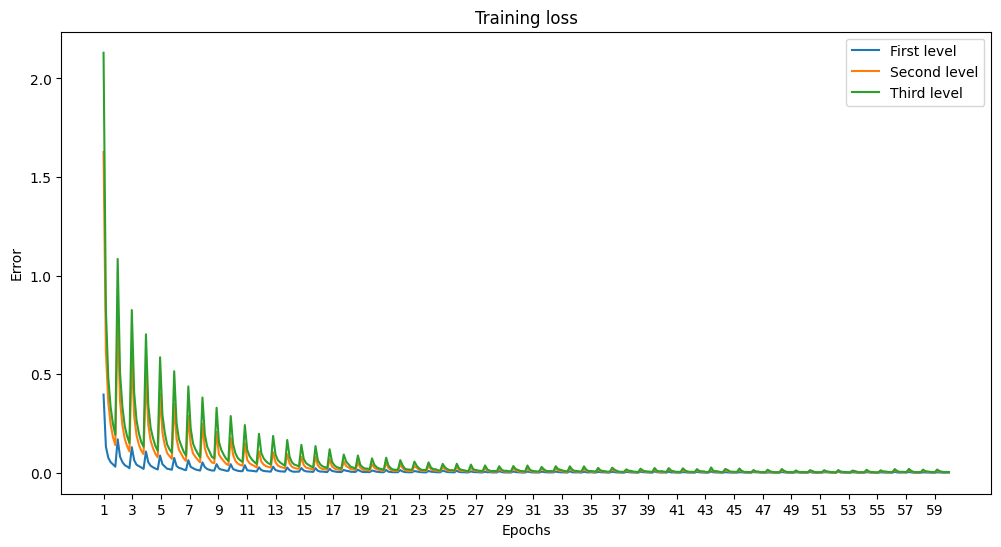

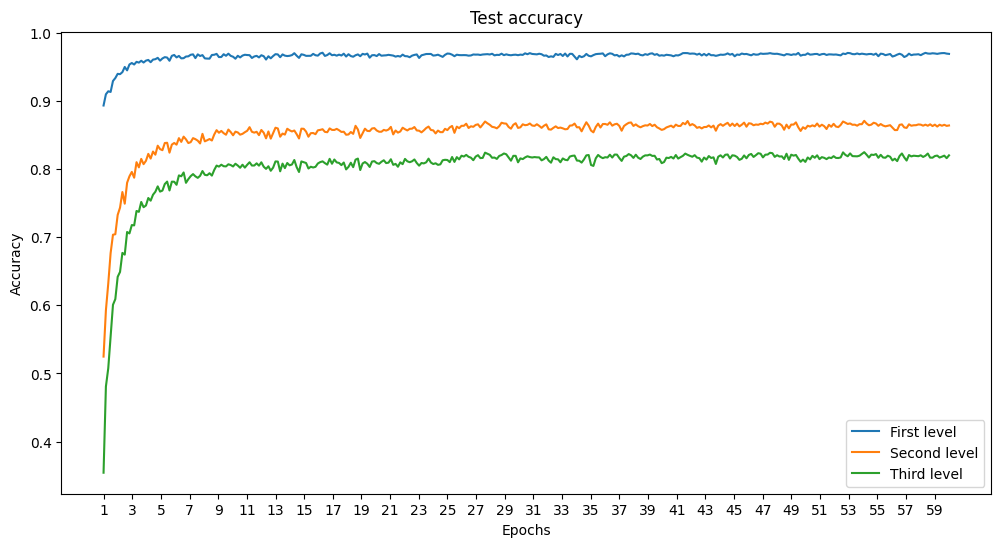

Accuracy for class transport: 97.38 %
Accuracy for class animal: 96.30 %

Accuracy for class sky  : 87.00 %
Accuracy for class water: 91.50 %
Accuracy for class road : 95.15 %
Accuracy for class bird : 70.50 %
Accuracy for class reptile: 86.10 %
Accuracy for class pet  : 86.70 %
Accuracy for class medium: 82.50 %

Accuracy for class plane: 86.30 %
Accuracy for class car  : 90.20 %
Accuracy for class bird : 70.40 %
Accuracy for class cat  : 69.90 %
Accuracy for class deer : 77.40 %
Accuracy for class dog  : 76.80 %
Accuracy for class frog : 86.10 %
Accuracy for class horse: 80.10 %
Accuracy for class ship : 91.70 %
Accuracy for class truck: 90.30 %

Accuracy on c1: 96.73 %
Accuracy on c2: 86.38 %
Accuracy on c3: 81.92 %

Cross-accuracy transport vs c2: 99.37 %
Cross-accuracy animal vs c2: 99.56 %

Cross-accuracy sky   vs c3: 97.97 %
Cross-accuracy water vs c3: 99.80 %
Cross-accuracy road  vs c3: 99.55 %
Cross-accuracy bird  vs c3: 98.66 %
Cross-accuracy reptile vs c3: 98.34 %
Cross-accu

In [8]:
#cnn.train_model(verbose = False)
err = False
filename = "models/B-CNN3_CIFAR10_H_d1_oca"

try:
    cnn.train_track(filename)
    cnn.save_model(filename+".pt")
    cnn.test(mode = "print")
    
except Exception as errore:
    err = errore

if err is False:
    bot.sendMessage("Programma terminato correttamente")
else:
    bot.sendMessage("Programma NON terminato correttamente\nTipo di errore: "+err.__class__.__name__+"\nMessaggio: "+str(err))
    raise err

In [9]:
total_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
total_params

1741880